In [1]:
from pandas_datareader import data as pdr
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
%matplotlib inline

import seaborn as sns

from hmmlearn.hmm import GaussianHMM as ghmm
import math
import copy
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:

#download data from yahoo! finance
"""
data source: http://finance.yahoo.com/
"""


class YahooDailyReader():
    
    def __init__(self, symbol=None, start=None, end=None):
        import datetime, time
        self.symbol = symbol
        
        # initialize start/end dates if not provided
        if end is None:
            end = datetime.datetime.today()
        if start is None:
            start = datetime.datetime(1980,2,1)
        
        self.start = start
        self.end = end
        
        # convert dates to unix time strings
        unix_start = int(time.mktime(self.start.timetuple()))
        day_end = self.end.replace(hour=23, minute=59, second=59)
        unix_end = int(time.mktime(day_end.timetuple()))
        
        url = 'https://finance.yahoo.com/quote/{}/history?'
        url += 'period1={}&period2={}'
        url += '&filter=history'
        url += '&interval=1d'
        url += '&frequency=1d'
        self.url = url.format(self.symbol, unix_start, unix_end)
        
    def read(self):
        import requests, re, json
       
        r = requests.get(self.url)
        
        ptrn = r'root\.App\.main = (.*?);\n}\(this\)\);'
        txt = re.search(ptrn, r.text, re.DOTALL).group(1)
        jsn = json.loads(txt)
        df = pd.DataFrame(
                jsn['context']['dispatcher']['stores']
                ['HistoricalPriceStore']['prices']
                )
        df.insert(0, 'symbol', self.symbol)
        df['Date'] = pd.to_datetime(df['date'], unit='s').dt.date
        
        # drop rows that aren't prices
        df = df.dropna(subset=['close'])
        
        df = df[['Date', 'high', 'low', 'open', 'close', 
                 'volume', 'adjclose']]
        df = df.set_index('Date')
        df.index=pd.to_datetime(df.index)
        return df
    



In [3]:
sp = YahooDailyReader('%5EGSPC').read() #s&p500
sp = sp.iloc[::-1]
dj = YahooDailyReader('%5EDJI').read() #dowjones30
dj = dj.iloc[::-1]
nsdq = YahooDailyReader('%5EIXIC').read() #nasdaq 
nsdq = nsdq.iloc[::-1]  #https://finance.yahoo.com/quote/%5EIXIC/history?p=%5EIXIC


In [4]:
#visual exploration

def viz(data,title) :
   
    plt.plot(data.index, data['adjclose'], 'r')
    plt.title(title)
    plt.ylabel('Price ($)');
    plt.rcParams['figure.figsize']=(20,13)
    plt.show();


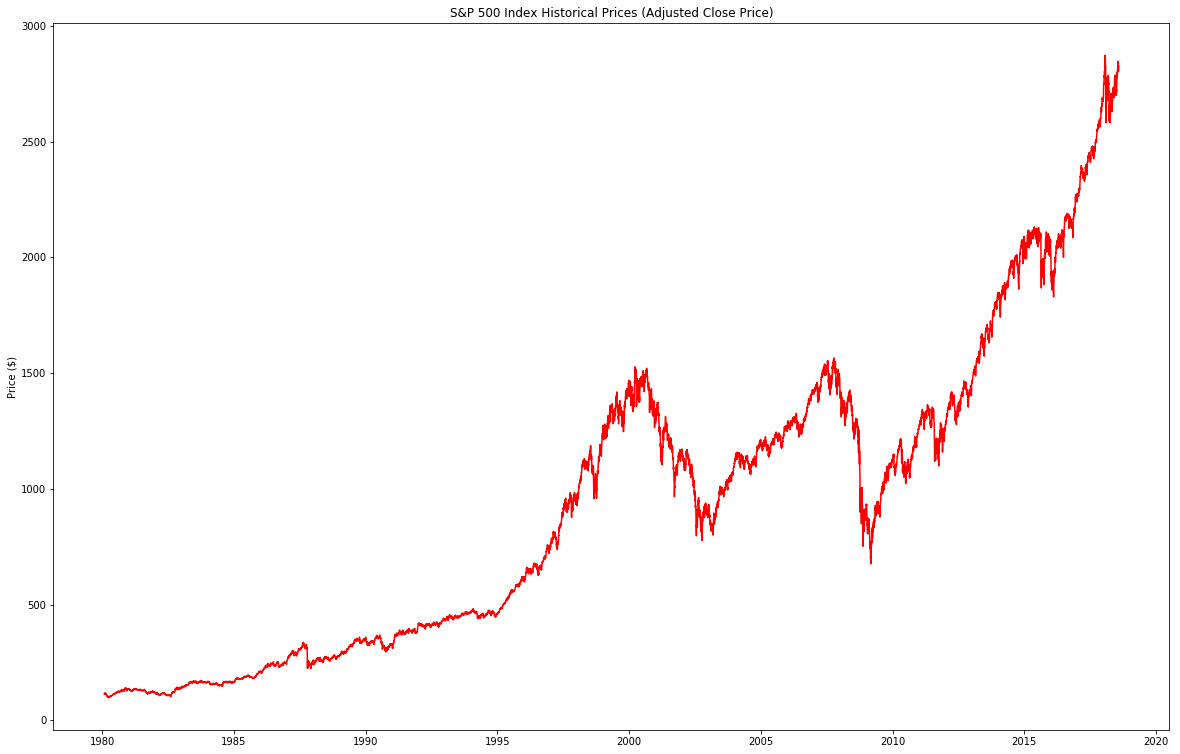

In [6]:
viz(sp,'S&P 500 Index Historical Prices (Adjusted Close Price)')

The risk management filter applied here works by training a Hidden Markov Model on S&P500 data from the 29th January 1993 (the earliest available data for SPY on Yahoo Finance) through to the 31st December 2004. This model is then serialised (via Python pickle) and utilised with a QSTrader RiskManager subclass.

In [13]:
train_sp=sp.loc[sp.index < pd.to_datetime('2018-06-01')] #January 31th 1980 - 31st May 2018

In order to carry out regime predictions using the Hidden Markov Model it is necessary to calculate and store the adjusted closing price returns of SPY. To date only the prices have been stored. The natural location to store the returns is in the PriceHandler subclass. However, QSTrader did not previously support this behaviour and so it has now been added as a feature.
The second change overrides the "virtual" method _store_event found in the AbstractBarPriceHandler class with the following in the YahooDailyCsvBarPriceHandler subclass.

The code checks if calc_adj_returns is equal to True. It stores the previous and current adjusted closing prices, modifying them with the PriceParser, calculates the percentage returns and then adds them to the adj_close_returns list. This list is later called by the RegimeHMMRiskManager in order to predict the current regime state:

In [14]:
def _store_event(self, event):
    """
    Store price event for closing price and adjusted closing price
    """
    ticker = event.ticker
    # If the calc_adj_returns flag is True, then calculate
    # and store the full list of adjusted closing price
    # percentage returns in a list
    if self.calc_adj_returns:
        prev_adj_close = self.tickers[ticker][
            "adj_close"
        ] / PriceParser.PRICE_MULTIPLIER
        cur_adj_close = event.adj_close_price / PriceParser.PRICE_MULTIPLIER
        self.tickers[ticker][
            "adj_close_ret"
        ] = cur_adj_close / prev_adj_close - 1.0
        self.adj_close_returns.append(self.tickers[ticker]["adj_close_ret"])
    self.tickers[ticker]["close"] = event.close_price
    self.tickers[ticker]["adj_close"] = event.adj_close_price
    self.tickers[ticker]["timestamp"] = event.time

There are four separate files required for this strategy to be carried out. The full listings of each are provided at the end of the article. This will allow straightforward replication of the results for those wishing to implement a similar method.

The first file encompasses the fitting of a Gaussian Hidden Markov Model to a large period of the S&P500 returns. The second file contains the logic for carrying out the short-term trend-following. The third file provides the regime filtering of trades through a risk manager object. The final file ties all of these modules together into a backtest.


# Training the Hidden Markov Model

Prior to the creation of a regime detection filter it is necessary to fit the Hidden Markov Model to a set of returns data. For this the Python hmmlearn library will be used. The API is exceedingly simple, which makes it straightforward to fit and store the model for later use.

The first task is to import the necessary libraries. pickle is necessary to serialise the model for use in the regime detection risk manager. warnings is used to suppress the excessive deprecation warnings generated by Scikit-Learn, through API calls from hmmlearn. GaussianHMM is imported from hmmlearn forming the basis of the model. Matplotlib and Seaborn are imported to plot the in-sample hidden states, necessary for a "sanity check" on the models behaviour:

In [15]:
# regime_hmm_train.py

from __future__ import print_function

import datetime
import pickle
import warnings

from hmmlearn.hmm import GaussianHMM
from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
import numpy as np
import pandas as pd
import seaborn as sns

In [17]:
def obtain_prices_df(data, a):
    """
    Obtain the prices DataFrame from the CSV file,
    filter by the end date and calculate the
    percentage returns.
    """
    df = pd.DataFrame(data)
    df["Returns"] = df[a].pct_change()
   
    df.dropna(inplace=True)
    return df

In [19]:
train_sp=obtain_prices_df(train_sp,'adjclose')

In [27]:
X

array([[  8.40924189e-03,   4.66100000e+07],
       [ -6.51494078e-03,   4.30700000e+07],
       [  2.53563792e-03,   4.18800000e+07],
       ..., 
       [ -1.15641873e-02,   3.73689000e+09],
       [  1.26957912e-02,   3.56105000e+09],
       [ -6.87955997e-03,   4.23537000e+09]])

# 1 Run Gaussian HMM

https://hmmlearn.readthedocs.io/en/latest/auto_examples/plot_hmm_stock_analysis.html#sphx-glr-auto-examples-plot-hmm-stock-analysis-py
 Take diff of close value. Note that this makes
 ``len(diff) = len(close_t) - 1``, therefore, other quantities also
 need to be shifted by 1, or just drop na


In [26]:
# Pack diff and volume for training.
X = np.column_stack([train_sp.Returns, train_sp.volume])

In [28]:
print("fitting to HMM and decoding ...", end="")

# Make an HMM instance and execute fit
model = GaussianHMM(n_components=4, covariance_type="diag", n_iter=1000).fit(X)

# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(X)

print("done")

fitting to HMM and decoding ...done


Transition matrix
[[  9.98706935e-01   3.46676434e-70   8.31529404e-04   4.61535960e-04]
 [  3.44983107e-69   9.82143442e-01   2.10415821e-03   1.57523999e-02]
 [  9.43744757e-04   2.75315163e-03   9.96302806e-01   2.97801886e-07]
 [  2.31716021e-03   4.81921602e-02   7.15471559e-04   9.48775208e-01]]

Means and vars of each hidden state
0th hidden state
mean =  [  5.26911135e-04   1.56194155e+08]
var =  [  7.84002174e-05   7.51142819e+15]

1th hidden state
mean =  [  7.02038431e-04   3.31716809e+09]
var =  [  5.49881222e-05   4.88638355e+17]

2th hidden state
mean =  [  3.81370729e-04   1.01685043e+09]
var =  [  1.36164066e-04   1.96727840e+17]

3th hidden state
mean =  [ -1.25904542e-03   5.22246798e+09]
var =  [  5.42780519e-04   1.75993926e+18]



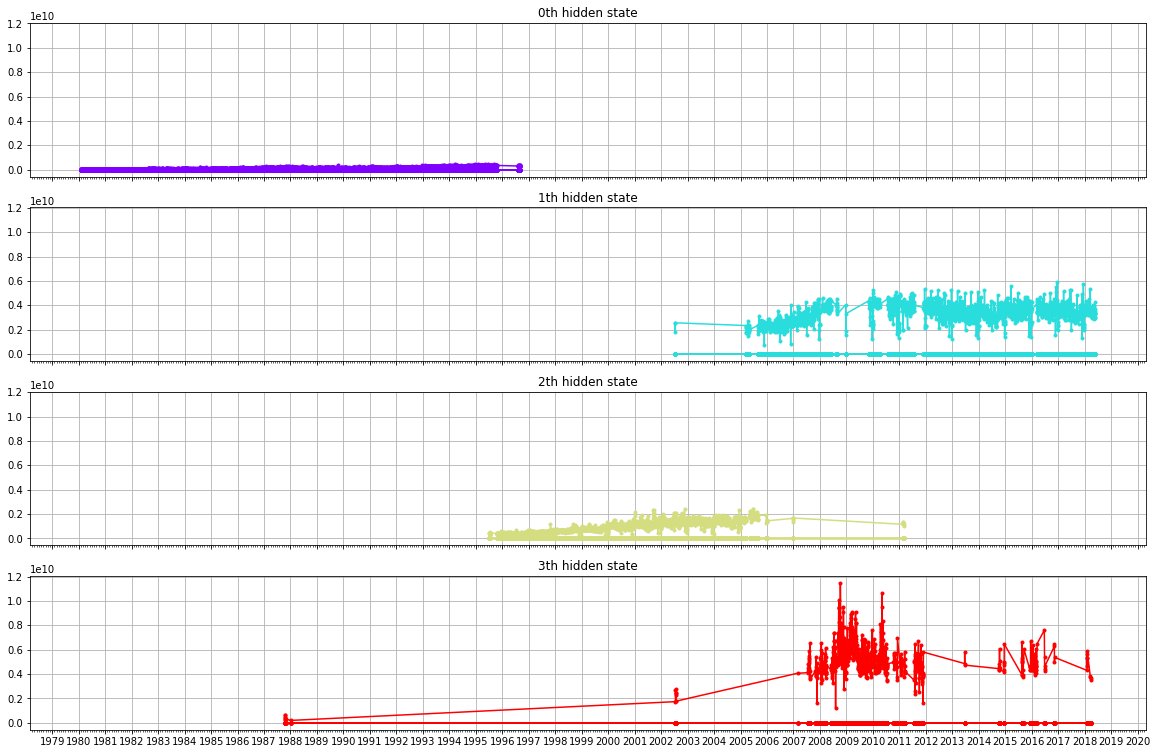

In [41]:
print("Transition matrix")
print(model.transmat_)
print()

print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covars_[i]))
    print()

fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True)
colours = cm.rainbow(np.linspace(0, 1, model.n_components))
for i, (ax, colour) in enumerate(zip(axs, colours)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(train_sp.index[mask], train_sp.values[mask], ".-", c=colour)
    ax.set_title("{0}th hidden state".format(i))

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())

    ax.grid(True)

plt.show()

In [32]:
hidden_states

array([0, 0, 0, ..., 1, 1, 1])

In [40]:
train_sp.index.values[mask]

array(['1980-02-01T00:00:00.000000000', '1980-02-04T00:00:00.000000000',
       '1980-02-05T00:00:00.000000000', ...,
       '1996-09-05T00:00:00.000000000', '1996-09-06T00:00:00.000000000',
       '1996-09-09T00:00:00.000000000'], dtype='datetime64[ns]')

# Back to our subject 

In [47]:
def plot_in_sample_hidden_states(hmm_model, df):
    """
    Plot the adjusted closing prices masked by
    the in-sample hidden states as a mechanism
    to understand the market regimes.
    """
    # Predict the hidden states array
    hidden_states = hmm_model.predict(rets)
    # Create the correctly formatted plot
    fig, axs = plt.subplots(
        hmm_model.n_components,
        sharex=True, sharey=True
    )
    colours = cm.rainbow(
        np.linspace(0, 1, hmm_model.n_components)
    )
    for i, (ax, colour) in enumerate(zip(axs, colours)):
        mask = hidden_states == i
        ax.plot_date(
            df.index[mask],
            df["adjclose"][mask],
            ".", linestyle='none',
            c=colour
        )
        ax.set_title("Hidden State #%s" % i)
        ax.xaxis.set_major_locator(YearLocator())
        ax.xaxis.set_minor_locator(MonthLocator())
        ax.grid(True)
    plt.show()

Model Score: 31445.8687023


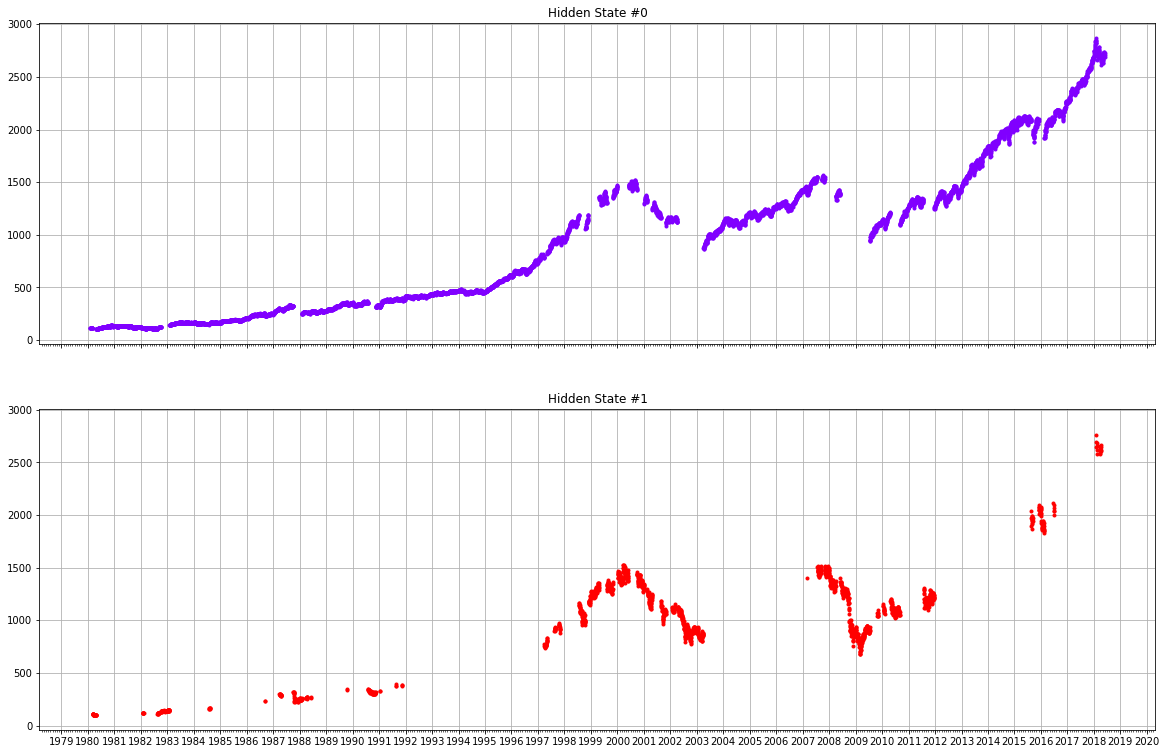

...HMM model pickled.


In [51]:
    warnings.filterwarnings("ignore")

    # Create the SPY dataframe from the Yahoo Finance CSV
    # and correctly format the returns for use in the HMM

   
 
    rets = np.column_stack([train_sp["Returns"]])

# Create the Gaussian Hidden markov Model and fit it
    # to the SPY returns data, outputting a score
    hmm_model = GaussianHMM(
        n_components=2, covariance_type="full", n_iter=1000
    ).fit(rets)
    print("Model Score:", hmm_model.score(rets))
#Compute the log probability under the model.

    # Plot the in sample hidden states closing values
    plot_in_sample_hidden_states(hmm_model, train_sp)


    print("...HMM model pickled.")

It can be seen that the regime detection largely captures "trending" periods and highly volatile periods. In particular the majority of 2008 occurs in Hidden State #1.

This script is tied together in the __main__ function. Firstly all warnings are ignored. Strictly speaking this is not best practice, but in this instance there are many deprecation warnings generated by Scikit-Learn that obscure the desired output of the script.

The rets variable is created using the np.column_stack command. This is because hmmlearn requires a matrix of series objects, despite the fact that this is a univariate model (it only acts upon the returns themselves). Using NumPy in this manner puts it into the correct format.
The model is fitted and the score of the algorithm output. The hidden states masking the adjusted closing prices are plotted.